<a href="https://colab.research.google.com/github/martinez-ie/python_modelagem_de_dados/blob/main/RID138056_Desafio5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Contexto**

Uma empresa do ramo de e-commerce precisa levantar os indicadores de recência, frequência e ticket médio (RFM) dos seus clientes.

A saber RFM:

- R (Recency): Tempo que o cliente realizou a última compra (em dias)
- F (Frequency): Quantidade de compras realizadas pelo cliente
- M (Monetary): Valor do ticket médio gasto pelo cliente

Onde ticket médio = média do total gasto por pedido para cada cliente.



Etapa 01 - Leia o arquivo e inspecione os dados

In [7]:
!pip install sidetable
!pip install ydata-profiling

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sidetable
import missingno as msno

from ipywidgets import interact, widgets
from ydata_profiling import ProfileReport
from sklearn import datasets
from sklearn.preprocessing import scale, minmax_scale, power_transform

In [55]:
#"latin-1" para evitar problemas com caracteres especiais.

df  = pd.read_csv("data5.csv", encoding='latin-1')

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [56]:
#Análise exploratória dos dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [57]:
#Descrição estatística dos dados
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


02 - Valores faltantes na identificação do cliente

In [58]:
#CustumerId com dados faltantes

df[df['CustomerID'].isna()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,12/9/2011 10:26,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,12/9/2011 10:26,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,12/9/2011 10:26,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,12/9/2011 10:26,10.79,NaN,United Kingdom


In [59]:
#Quantidade de valores nulos em cada coluna do df.
df.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [19]:
#Remover dados nulos
df.dropna(inplace= True)

In [20]:
#Verificar se ainda existem dados nulos
df.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


03 - Preços unitários e quantidade de produtos iguais ou inferior a 0

In [60]:
#Contagem dos registros que possuem valores negativos
df.query('UnitPrice <=0 or Quantity <=0').count()

,0
InvoiceNo,11805
StockCode,11805
Description,10351
Quantity,11805
InvoiceDate,11805
UnitPrice,11805
CustomerID,8945
Country,11805


In [61]:
# Filtros que removem os valores menores ou iguais a zero:
filtro_preco = df['UnitPrice'] > 0
filtro_quantidade = df['Quantity'] > 0

# Adicionando filtros ao DF, Isso remove todas as linhas onde UnitPrice ou Quantity são menores ou iguais a zero.
df = df[filtro_preco & filtro_quantidade]
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [62]:
df.query('UnitPrice <=0 or Quantity <=0').count()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


# `04 - Verifique se existem linhas duplicadas`

In [25]:
df[df.duplicated(keep=False)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,12/9/2011 11:34,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,12/9/2011 11:34,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,12/9/2011 11:34,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,12/9/2011 11:34,2.10,14446.0,United Kingdom


In [26]:
df.duplicated().sum()

5192

In [29]:
 pd.options.mode.copy_on_write = True

In [28]:
df.duplicated().sum().any()

False

# `05 - Alterando tipos de dados`

In [30]:
df = df.astype({'CustomerID':'int'})
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392692 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  int64         
 7   Country      392692 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 27.0+ MB


06 - Tratando os outliers

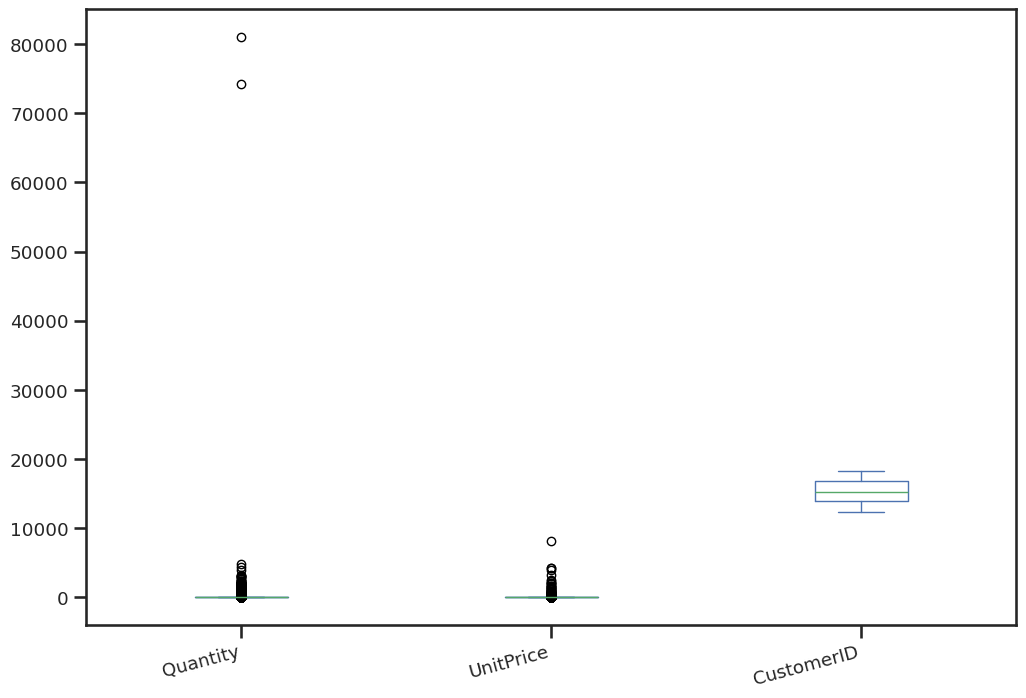

In [37]:
#Análise Gráfica
df.plot.box()
plt.xticks(rotation=15, ha='right');

In [38]:
df = df[(df['Quantity'] <= 10000) & (df['UnitPrice'] <= 5000)]

<Axes: >

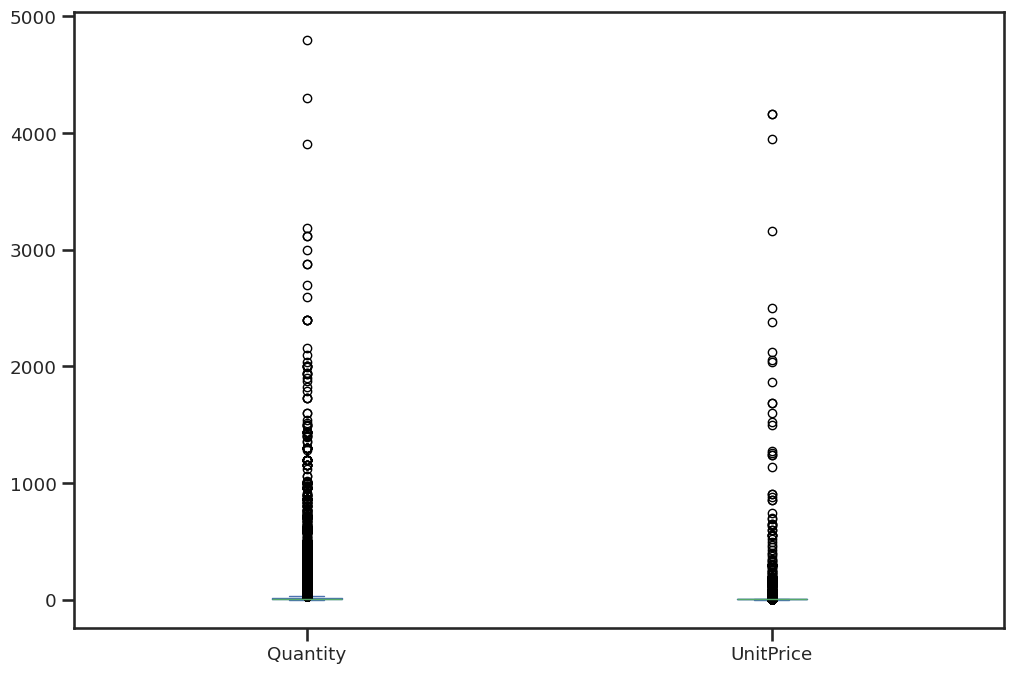

In [39]:
df[["Quantity","UnitPrice"]].plot.box()

In [40]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,392689.000000,392689,392689.000000,392689.000000
mean,12.724550,2011-07-10 19:13:27.579534848,3.105194,15287.846520
min,1.000000,2010-12-01 08:26:00,0.001000,12347.000000
25%,2.000000,2011-04-07 11:12:00,1.250000,13955.000000
50%,6.000000,2011-07-31 12:02:00,1.950000,15150.000000
75%,12.000000,2011-10-20 12:53:00,3.750000,16791.000000
max,4800.000000,2011-12-09 12:50:00,4161.060000,18287.000000
std,43.083696,NaN,18.055047,1713.538259


07 - Crie uma coluna adicional

In [41]:
df['TotalPrice'] = df['UnitPrice'] * df['Quantity']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


08 - Última data

In [42]:
ultima_compra = max(df["InvoiceDate"])

# `09 - Plotando gráficos`


- **Top 10 países com maior valor em vendas**
- **Top 10 produtos mais vendidos**
- **Valor de venda total por mês**
- **Valor de venda total por mês e por país (considere apenas os top 10)**



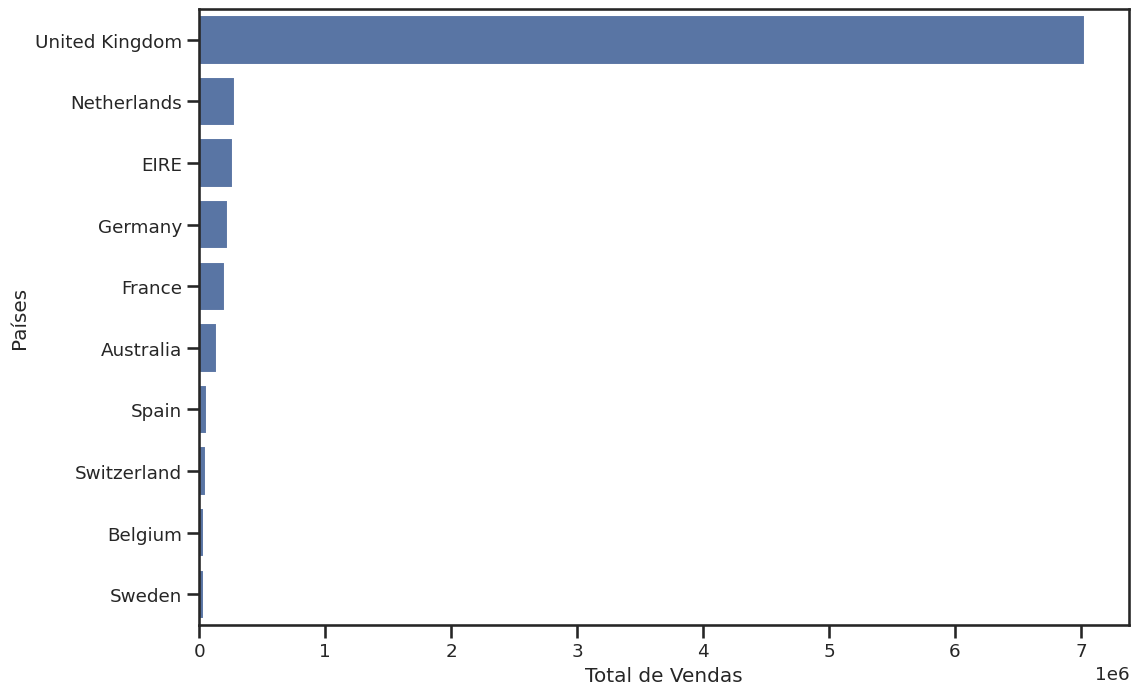

In [45]:
top_10_paises = df.groupby('Country').sum('TotalPrice').sort_values(by='TotalPrice', ascending=False).head(10)
sns.barplot(data=top_10_paises, y='Country', x='TotalPrice')
plt.xlabel('Total de Vendas');
plt.ylabel('Países');

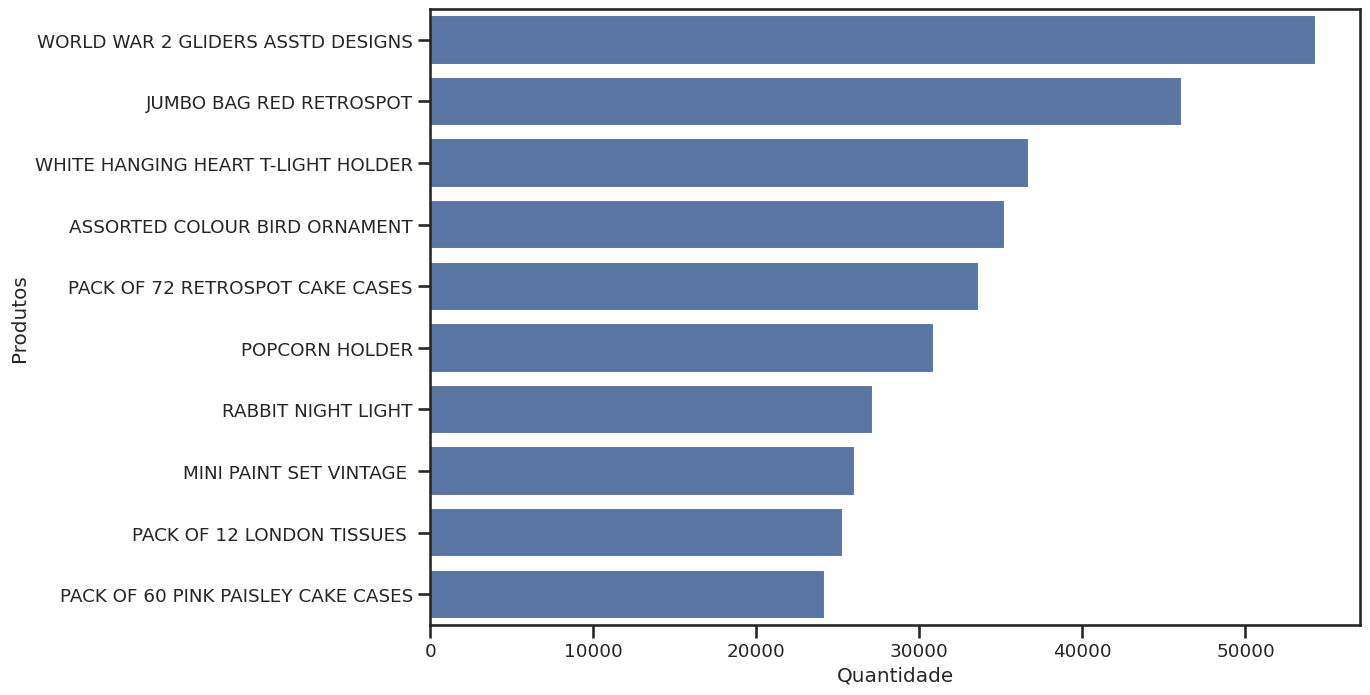

In [46]:
top_10_produtos = df.groupby('Description').sum('Quantity').sort_values(by='Quantity', ascending=False).head(10)
sns.barplot(data=top_10_produtos, y='Description', x='Quantity')
plt.xlabel('Quantidade');
plt.ylabel('Produtos');

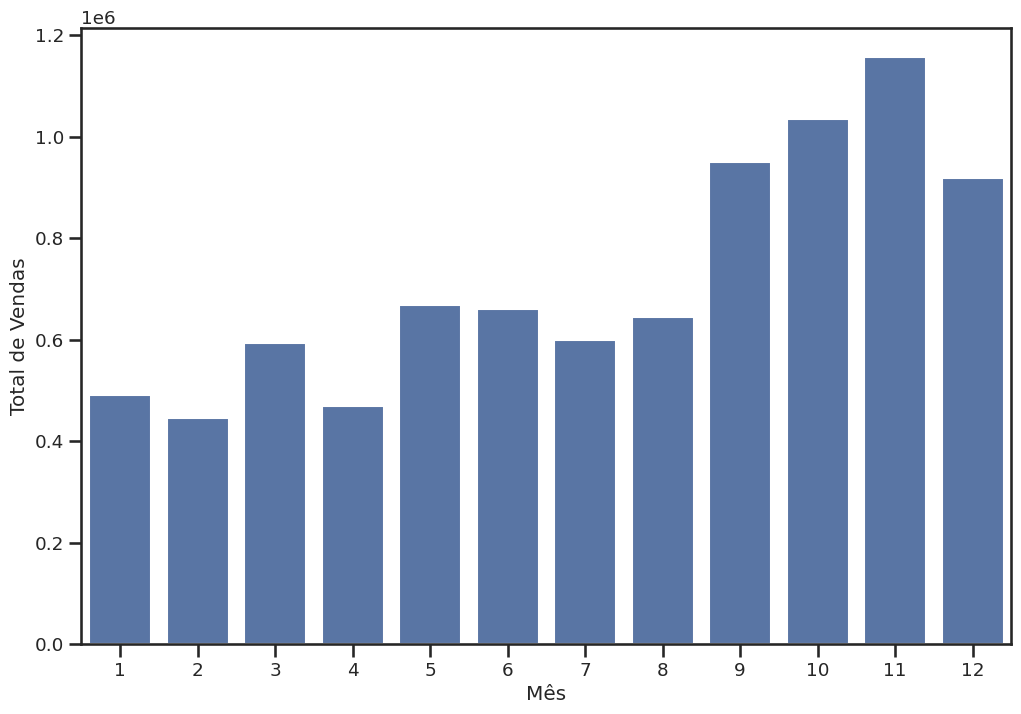

In [47]:
df['Mes'] = df['InvoiceDate'].dt.month
vendas_por_mes = df.groupby('Mes').sum('TotalPrice')

sns.barplot(data=vendas_por_mes, x='Mes', y='TotalPrice');
plt.xlabel('Mês');
plt.ylabel('Total de Vendas');

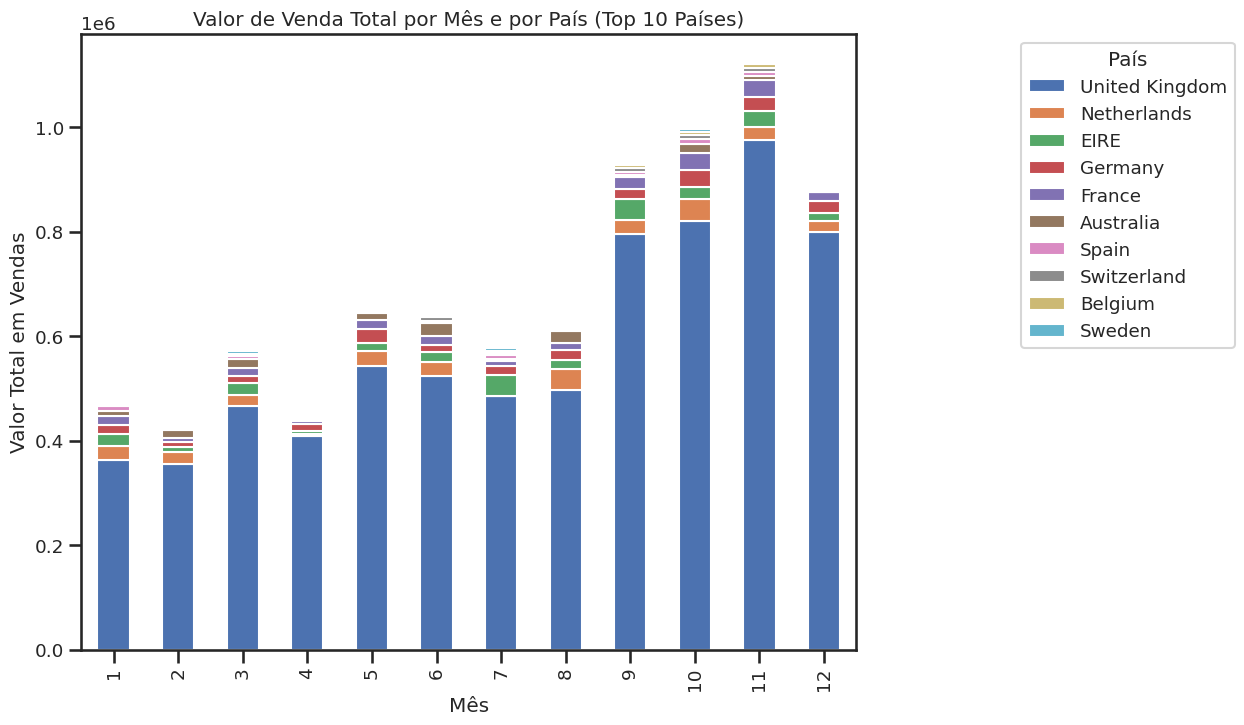

In [51]:
top_paises = df.groupby('Country')['TotalPrice'].sum().nlargest(10).index
venda_por_mes_pais = df[df['Country'].isin(top_paises)].groupby(['Mes', 'Country'])['TotalPrice'].sum().unstack()
venda_por_mes_pais = venda_por_mes_pais[top_paises].sort_index(ascending=True)  # Ordenar do maior para o menor
venda_por_mes_pais.plot(kind='bar', figsize=(10, 8), stacked=True)

# Plotando o gráfico
plt.title('Valor de Venda Total por Mês e por País (Top 10 Países)')
plt.xlabel('Mês')
plt.ylabel('Valor Total em Vendas')
plt.legend(title='País', loc='upper right', bbox_to_anchor=(1.5, 1))
plt.show()

# `10 - Cálculo do RFM`

In [52]:
data_ultima_compra = df['InvoiceDate'].max()

In [53]:
rfm = df.groupby('CustomerID').agg(
    Recencia=('InvoiceDate', lambda x: (data_ultima_compra - x.max()).days),  # Recência
    Frequencia=('InvoiceNo', 'nunique'),  # Frequência
    TicketMedio=('TotalPrice', 'mean')  # Ticket Médio
).reset_index()

# Exibir o resultado
print(rfm.head())

   CustomerID  Recencia  Frequencia  TicketMedio
0       12347         1           7    23.681319
1       12348        74           4    57.975484
2       12349        18           1    24.076027
3       12350       309           1    19.670588
4       12352        35           8    29.482824
